In [30]:
!pip install matplotlib numpy > /dev/null
import numpy as np
import heapq
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from google.colab import files
from IPython.display import HTML, display
import io

In [31]:
from google.colab import files

uploaded = files.upload()

print("Archivos subidos:", list(uploaded.keys()))

# Definición de puntos
INICIO = (5, 3)  # Formato (fila, columna)
DESTINO = (16, 26)

Saving streets.npy to streets (5).npy
Archivos subidos: ['streets (5).npy']


In [32]:
CONDICIONES = {
    -10: {'costo': float('inf'), 'color': 'black', 'nombre': 'Edificio'},
    -1: {'costo': float('inf'), 'color': 'red', 'nombre': 'Calle cerrada'},
    1: {'costo': 1, 'color': 'lime', 'nombre': 'Buena condición'},
    2: {'costo': 2, 'color': 'tan', 'nombre': 'Camino de tierra'},
    4: {'costo': 4, 'color': 'dodgerblue', 'nombre': 'Con grietas'},
    5: {'costo': 5, 'color': 'peru', 'nombre': 'Con baches'}
}

def distancia_manhattan(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def buscar_ruta_optima(mapa, inicio, destino):
    frontera = []
    heapq.heappush(frontera, (0, inicio))
    procedencia = {}
    costo_acumulado = {inicio: 0}

    while frontera:
        _, actual = heapq.heappop(frontera)

        if actual == destino:
            break

        for dx, dy in [(0,1), (1,0), (0,-1), (-1,0)]:
            x, y = actual[0] + dx, actual[1] + dy
            vecino = (x, y)

            if (0 <= x < mapa.shape[0] and 0 <= y < mapa.shape[1]
                and mapa[x,y] not in [-10, -1]):

                nuevo_costo = costo_acumulado[actual] + CONDICIONES[mapa[x,y]]['costo']

                if vecino not in costo_acumulado or nuevo_costo < costo_acumulado[vecino]:
                    costo_acumulado[vecino] = nuevo_costo
                    prioridad = nuevo_costo + distancia_manhattan(vecino, destino)
                    heapq.heappush(frontera, (prioridad, vecino))
                    procedencia[vecino] = actual

    # Reconstruir camino
    camino = []
    if destino in procedencia:
        actual = destino
        while actual != inicio:
            camino.append(actual)
            actual = procedencia[actual]
        camino.append(inicio)
        camino.reverse()
        return camino, costo_acumulado[destino]
    return None, float('inf')

camino, costo_total = buscar_ruta_optima(calles, INICIO, DESTINO)

⚠️ No se encontró una ruta válida


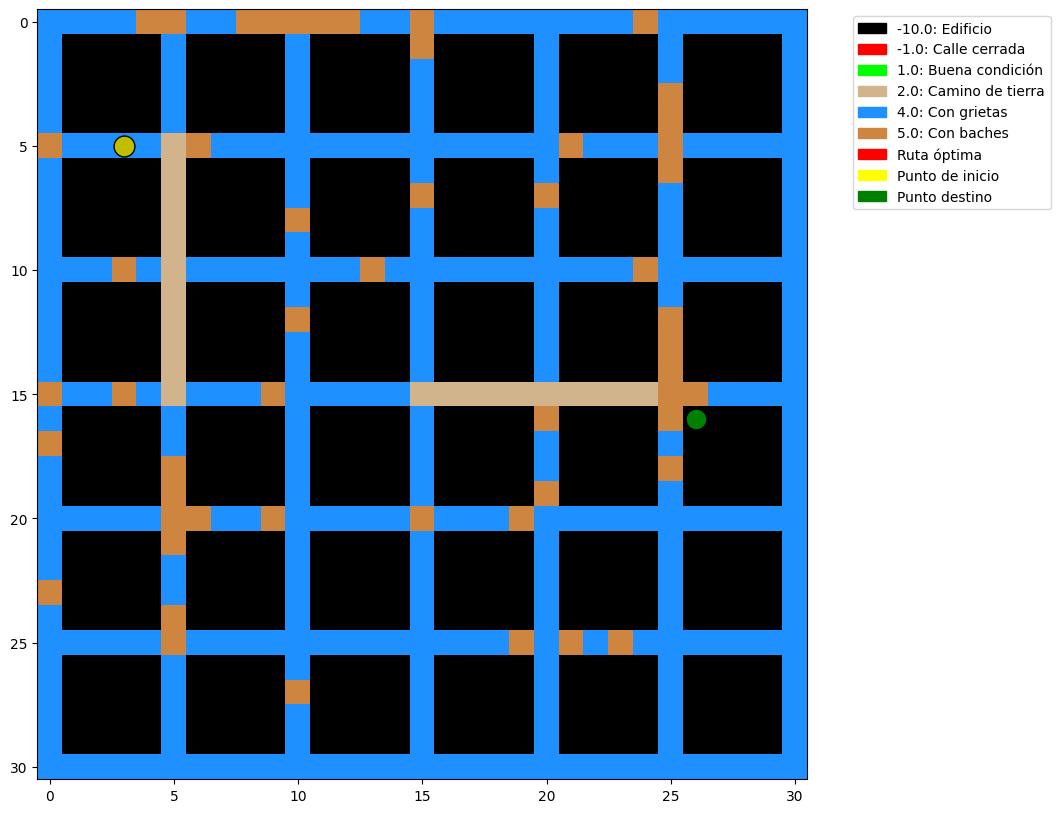

In [36]:
# Configuración del mapa
fig, ax = plt.subplots(figsize=(12, 10))
colores = [CONDICIONES[val]['color'] for val in np.unique(calles)]
cmap = ListedColormap(colores)
img = ax.imshow(calles, cmap=cmap, zorder=1)

# Dibujar ruta y puntos
linea, = ax.plot([], [], 'r-', linewidth=3, zorder=2)
agente = ax.plot([], [], 'ro', markersize=10, zorder=4)[0]
ax.plot(INICIO[1], INICIO[0], 'yo', markersize=15, markeredgecolor='black', zorder=3, label='Inicio')
ax.plot(DESTINO[1], DESTINO[0], 'go', markersize=15, markeredgecolor='black', zorder=3, label='Destino')

# Leyenda mejorada
leyenda = [mpatches.Patch(color=CONDICIONES[val]['color'], label=f"{val}: {CONDICIONES[val]['nombre']}")
           for val in np.unique(calles)]
leyenda.extend([
    mpatches.Patch(color='red', label='Ruta óptima'),
    mpatches.Patch(color='yellow', label='Punto de inicio'),
    mpatches.Patch(color='green', label='Punto destino')
])
ax.legend(handles=leyenda, bbox_to_anchor=(1.05, 1), loc='upper left')

# Animación mejorada
def init():
    linea.set_data([], [])
    agente.set_data([], [])
    ax.set_title("Buscando ruta óptima...")
    return linea, agente

def animate(i):
    x = [p[1] for p in camino[:i+1]]
    y = [p[0] for p in camino[:i+1]]
    linea.set_data(x, y)
    agente.set_data(x[-1], y[-1])

    # Cálculo del costo
    costo_actual = 0
    for p in camino[:i+1]:
        costo_actual += CONDICIONES[calles[p[0], p[1]]]['costo']

    ax.set_title(f"Agente en movimiento\nPaso {i+1}/{len(camino)} - Costo acumulado: {costo_actual}/{costo_total}")

    # Resaltar posición actual
    for artist in ax.collections:
        artist.remove()
    ax.scatter(x[-1], y[-1], s=200, facecolors='none', edgecolors='gold', linewidths=2, zorder=5)

    return linea, agente

if camino:
    anim = FuncAnimation(fig, animate, frames=len(camino),
                        init_func=init, blit=True, interval=300)
    plt.close()
    display(HTML(anim.to_jshtml()))
else:
    print("⚠️ No se encontró una ruta válida")